In [1]:
import sys
sys.path.append('../')

from src.m4_generator import M4Generator
from src.m4_data_loader import M4DataLoader
from src.m4_evaluation_loss_functions import *
from src.training_loss_functions import *
from src.visualization import *
from src.evaluation import *
from src.data_augmentations import *
from src.m4_model import M4Model


import numpy as np
import keras
import matplotlib.pyplot as plt

import tensorflow as tf

%matplotlib inline
keras.backend.set_floatx('float64')

Using TensorFlow backend.


# Load Data

In [2]:
EPOCHS = 1
BATCH_SIZE = 50
LOOKBACK = 48
HORIZON = 48
HIDDEN_LAYER_SIZE = 120
FEATURES_NUMBER = 2
OUTPUT_SIZE = HORIZON*2
LOSS = kl_divergance_diff
PI_PARAMS = {'max_coff': 0.25, 'min_coff': 0.15, 'step': 0.1}

stdAugmentation = StdAugmentation(PI_PARAMS)
diffAugmentation = DiffAugmentation()
x_augmentations = [stdAugmentation]
y_augmentations = [stdAugmentation]

data_loader = M4DataLoader("../Dataset/Train/Hourly-train.csv", "../Dataset/Test/Hourly-test.csv", 
                           x_augmentations, 
                           y_augmentations,
                           LOOKBACK, HORIZON,  validation_ratio=0.05)

train_x, train_y = data_loader.get_training_data()
test_x, test_y = data_loader.get_test_data()
validate_x, validate_y = data_loader.get_validation_data()

training_data_generator = M4Generator(train_x, train_y, BATCH_SIZE, FEATURES_NUMBER)
test_data_generator = M4Generator(test_x, test_y, BATCH_SIZE, FEATURES_NUMBER)
validation_data_generator = M4Generator(validate_x, validate_y, BATCH_SIZE, FEATURES_NUMBER)

# Train The Model

In [8]:
model = M4Model(hidden_layer_size=HIDDEN_LAYER_SIZE, batch_size=BATCH_SIZE, lookback=LOOKBACK, 
                output_size=OUTPUT_SIZE, learning_rate=0.001, loss = LOSS,
                dropout_ratio = 0.5, features_number = FEATURES_NUMBER, callbacks = [], pi_params=PI_PARAMS)

In [9]:
model.train(training_data_generator, test_data_generator, epochs=EPOCHS)

hist = model.evaluate(validation_data_generator)
print(hist)

Epoch 1/1
8/8 [==============================] - 0s 23ms/step
41.77773859585896


# Save The Model

In [15]:
MODEL_BASE_DIR = '../models/kl_divergance/3-LSTM'
model.save(MODEL_BASE_DIR)

Saved model files to disk under../models/with_kl_pi_params/3-LSTM/23


# Get Best And Worst Predictions

Loaded model from disk
Missing key'learning_rate'
Best Predection Error is     5.5427
Worst Predection Error is   149.9236


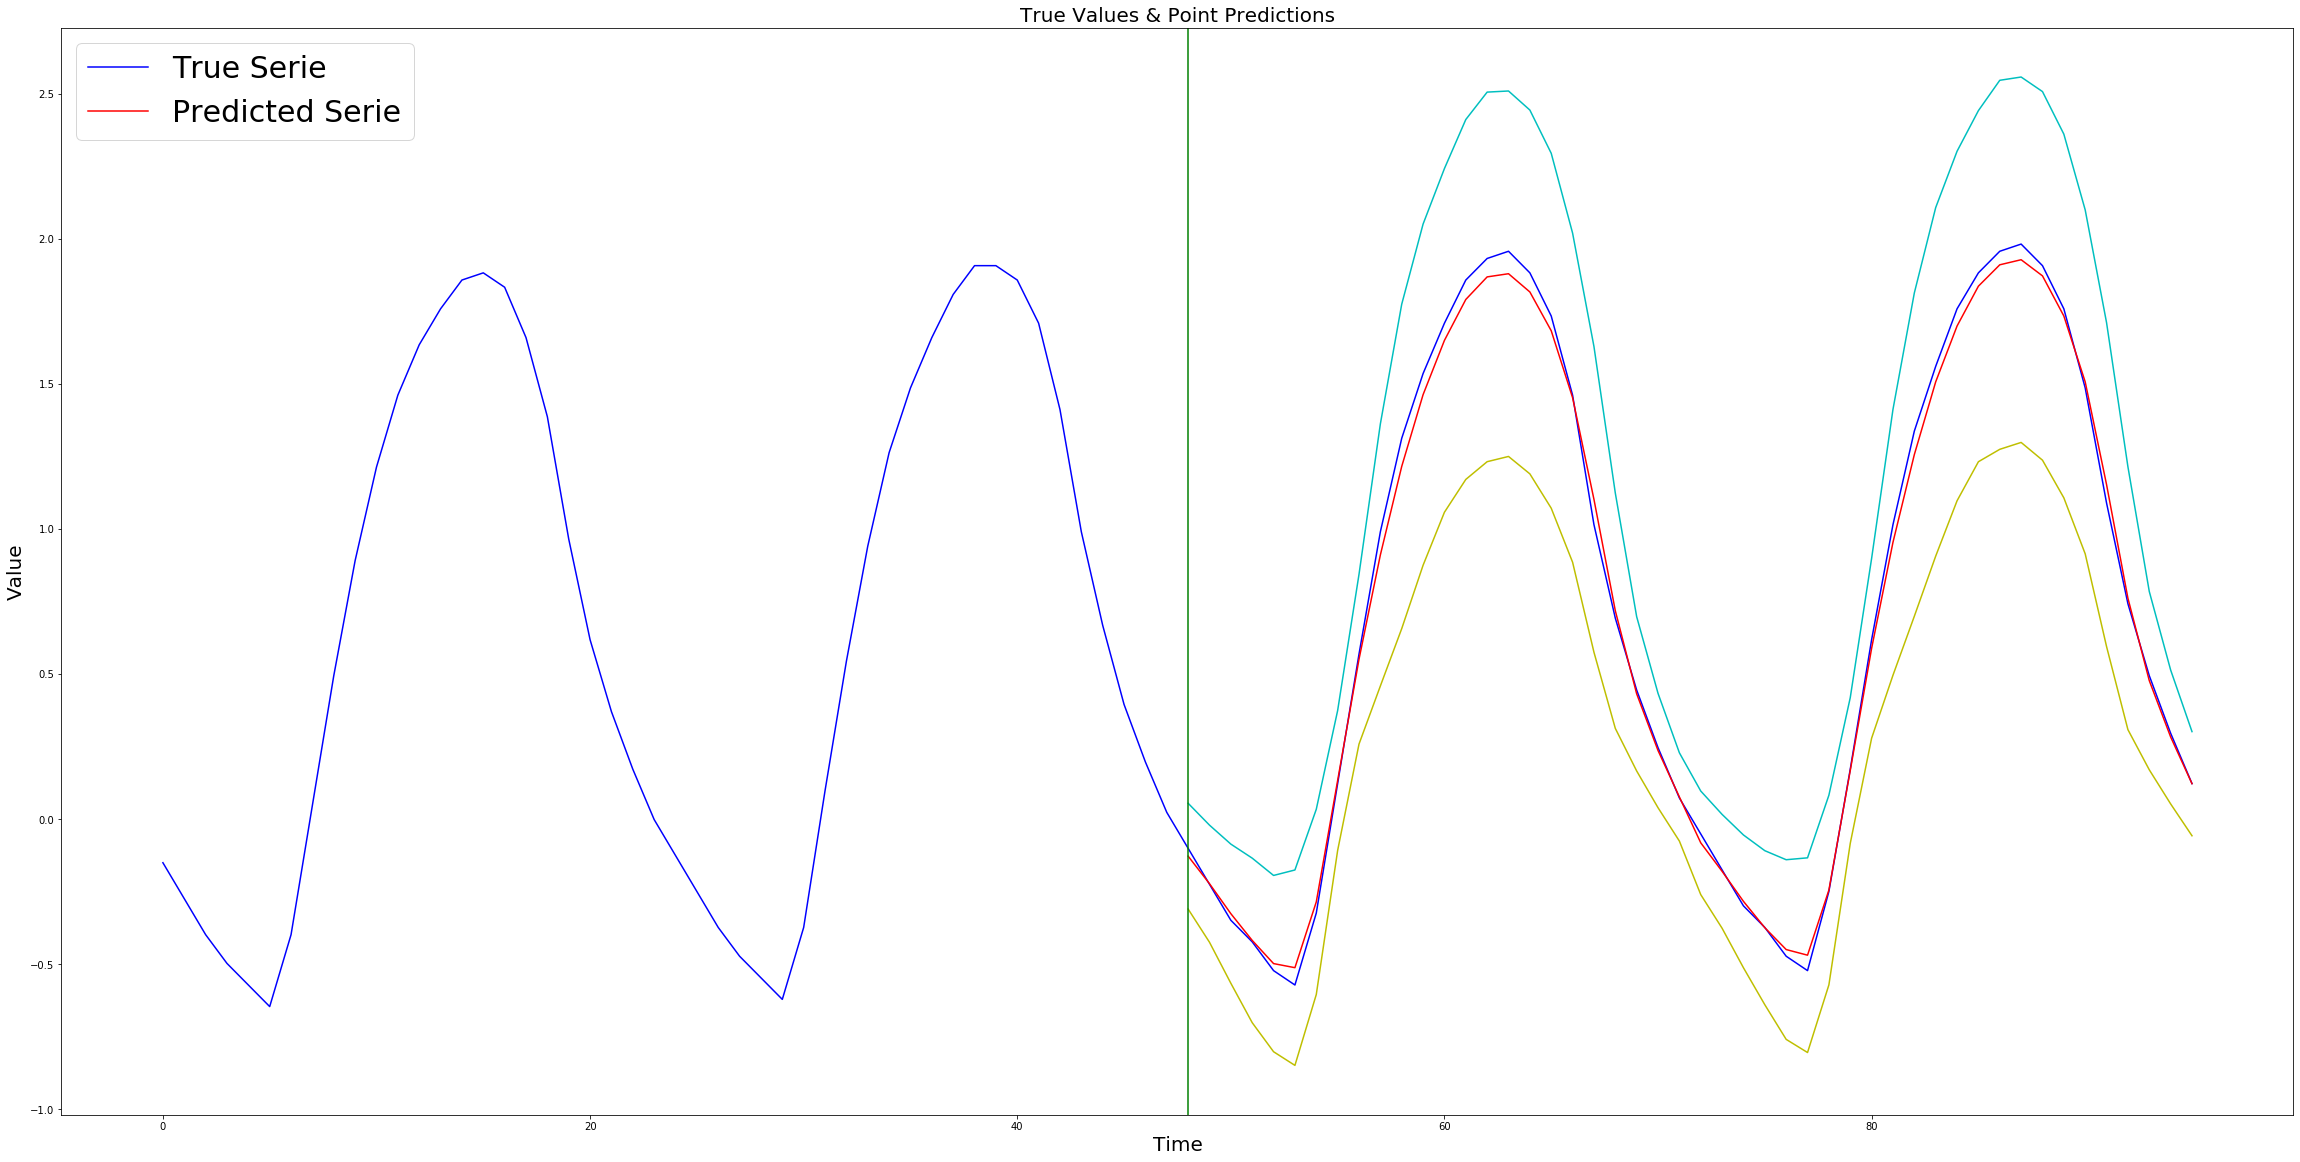

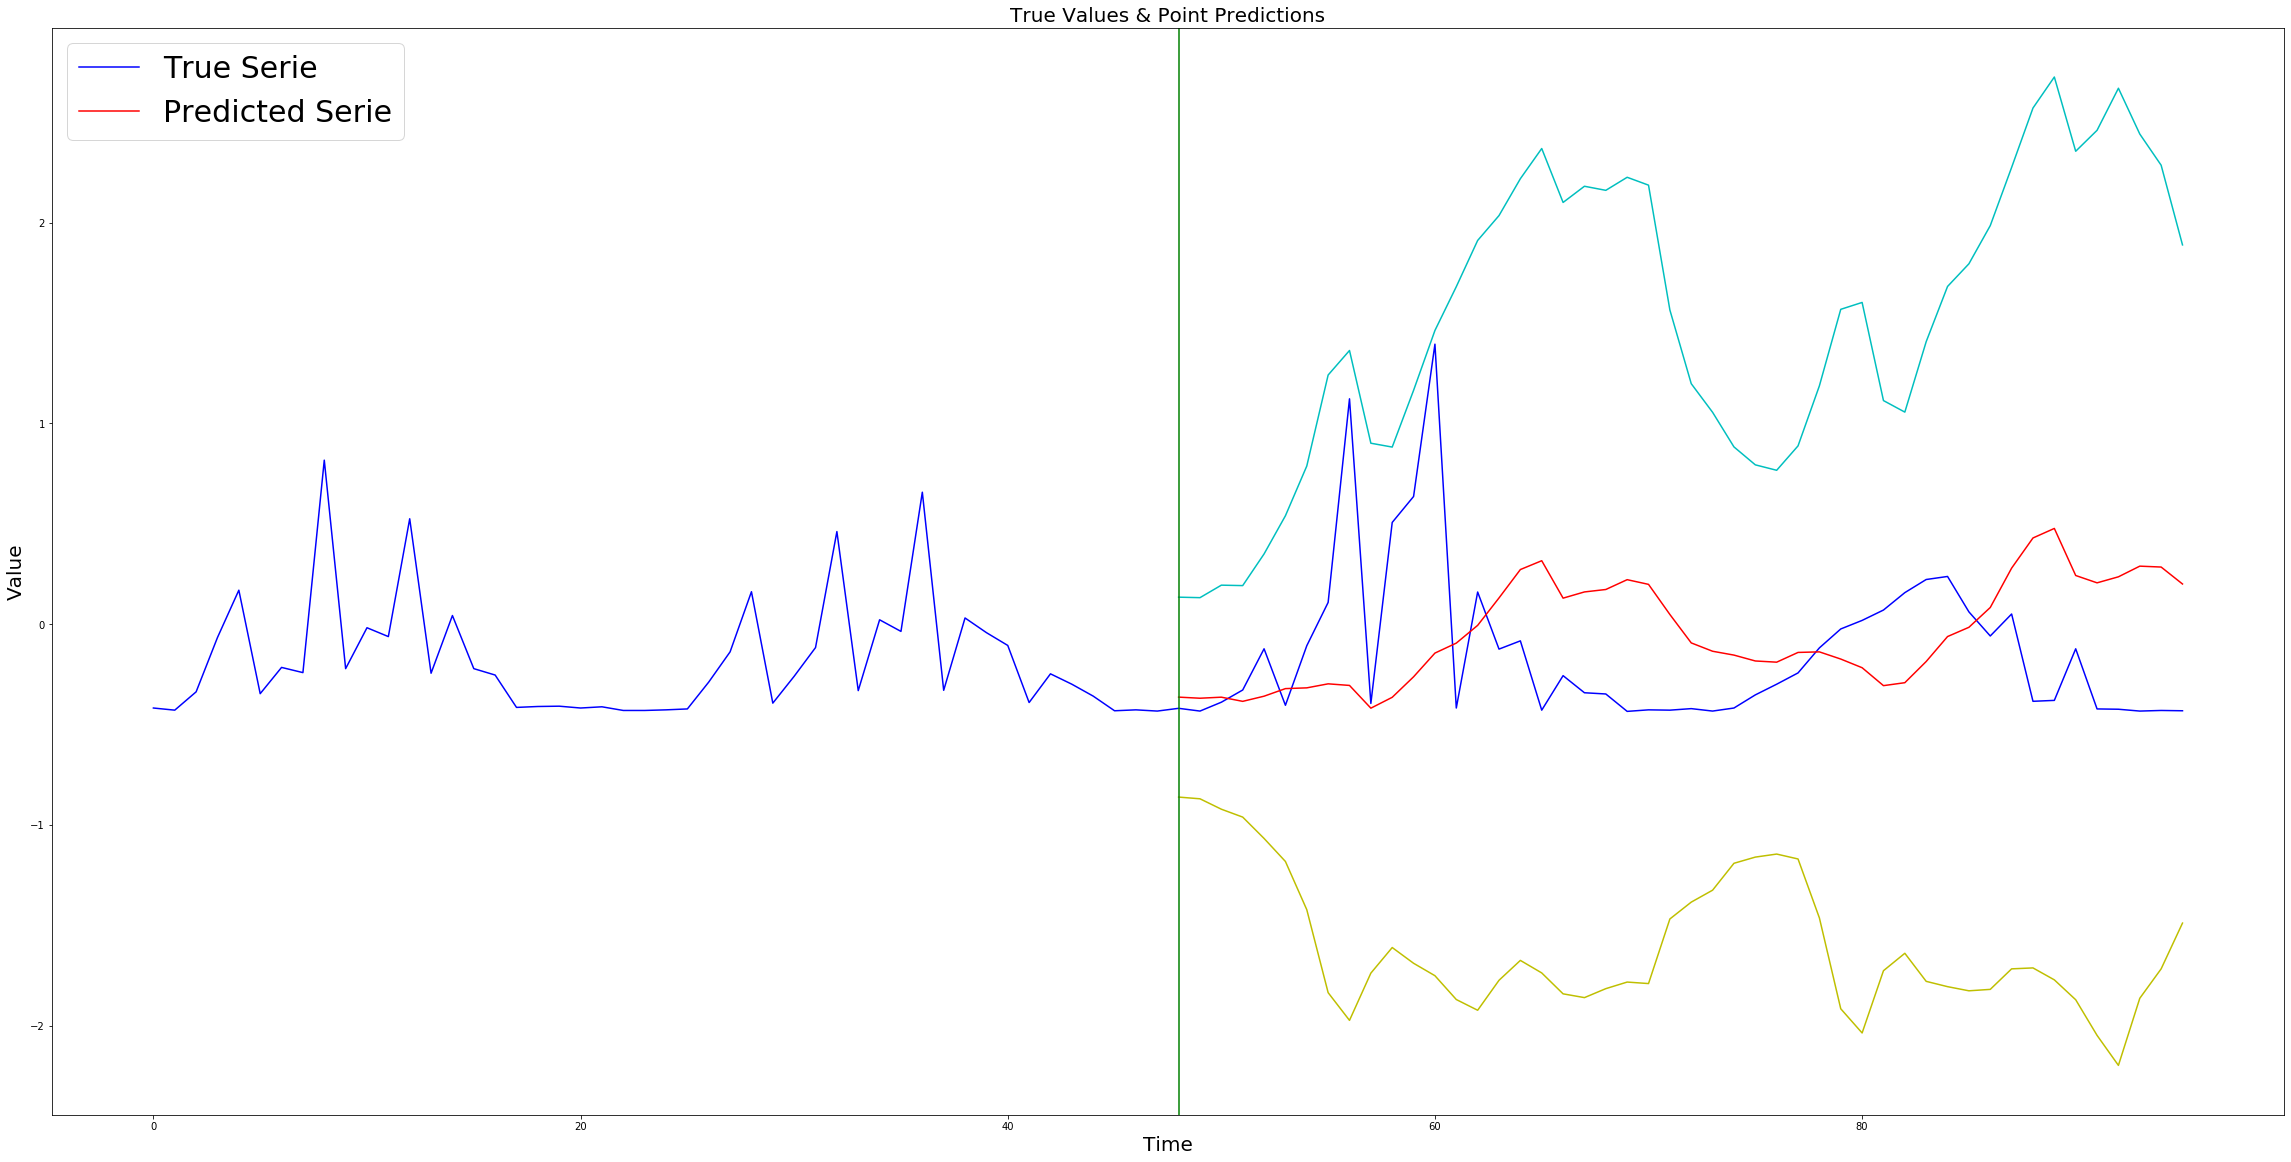

In [5]:
MODEL_BASE_DIR = '../models/kl_divergance/3-LSTM/9'
model = M4Model()
hyperparameters = model.load(MODEL_BASE_DIR)

X, Y, Ypredictions, error =  sort_by_prediction_error(model,test_x, test_y, smape)

if FEATURES_NUMBER == 1:
    X = X[:,:, np.newaxis]

print(f'Best Predection Error is {error[0]:10.4f}')
print(f'Worst Predection Error is {error[X.shape[0]-1]:10.4f}')

lower_bound = Ypredictions[:,:48] - 2*tf.abs(Ypredictions[:,-48:])
upper_bound = Ypredictions[:,:48] + 2*tf.abs(Ypredictions[:,-48:])

plot_serie_with_bounds(X[:,:,0], Y[:,:HORIZON], Ypredictions[:,:HORIZON], lower_bound, upper_bound, serie_indx=0,  save_path='../../Presentations/second_pres/kl_best.png')
plot_serie_with_bounds(X[:,:,0], Y[:,:HORIZON], Ypredictions[:,:HORIZON], lower_bound, upper_bound, serie_indx=X.shape[0]-1,  save_path='../../Presentations/second_pres/kl_worst.png')

# PLot Specific Serie From A Batch

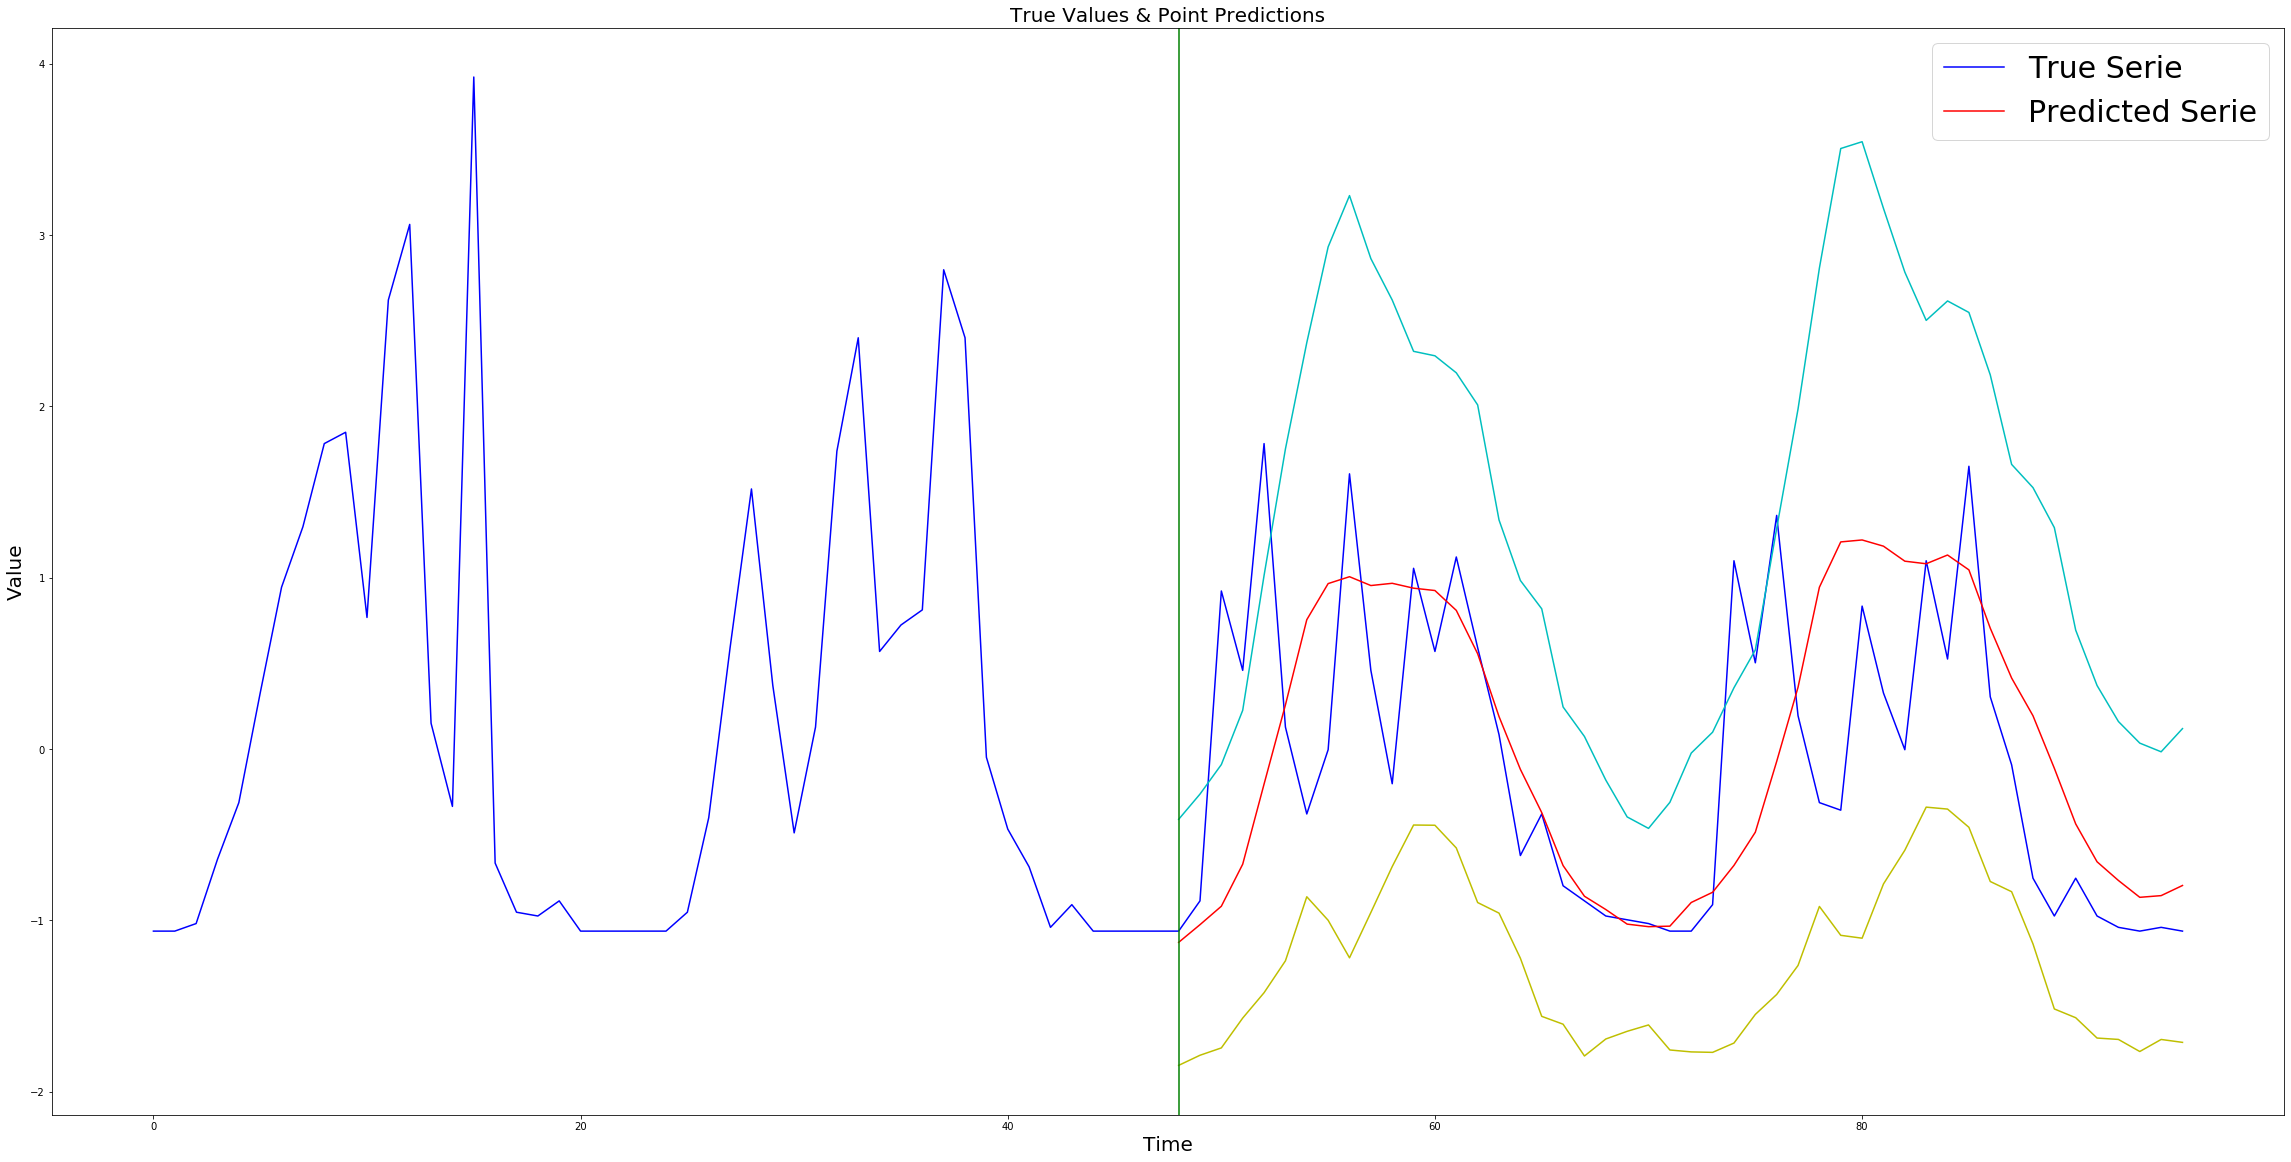

In [31]:
IDX = 130
X = test_x
Y = test_y
predictedY = model.predict(X)

lower_bound = predictedY[:,:48] - 2*tf.abs(predictedY[:,-48:])
upper_bound = predictedY[:,:48] + 2*tf.abs(predictedY[:,-48:])

if FEATURES_NUMBER == 1:
    X = X[:,:, np.newaxis]

#============ Predict Test
plot_serie_with_bounds(X[:,:,0], Y[:,:HORIZON], predictedY[:,:HORIZON], lower_bound, upper_bound, serie_indx=IDX)

# Evaluate A Model Against An Error Function

In [4]:
MODEL_NUMBER = 9
MODEL_BASE_DIR = '../models/kl_divergance/3-LSTM'
evaluation_results = load_and_evaluate_model(f'{MODEL_BASE_DIR}/{MODEL_NUMBER}', '../Dataset/Train/Hourly-train.csv', 
                                             '../Dataset/Test/Hourly-test.csv', 
                                             x_augmentations, 
                                             y_augmentations, m4_mase)

print(f'Hyperparameters : {evaluation_results["hyperparameters"]}')
print(f'Test Error For Model ({MODEL_NUMBER}) : {evaluation_results["test_error"]}')
print(f'Naive Test Error For Model ({MODEL_NUMBER}) : {evaluation_results["naive_test_error"]}')
      
print(f'SNaive Test Error For Model ({MODEL_NUMBER}) : {evaluation_results["snaive_test_error"]}')

print(f'Validation Error For Model ({MODEL_NUMBER}) : {evaluation_results["validation_error"]}')
print(f'Naive Validation Error For Model ({MODEL_NUMBER}) : {evaluation_results["naive_validation_error"]}')
print(f'SNaive Validation Error For Model ({MODEL_NUMBER}) : {evaluation_results["snaive_validation_error"]}')


Loaded model from disk
Missing key'learning_rate'
Hyperparameters : {'epochs': 200, 'batch_size': 128, 'hidden_layer_size': 20, 'lookback': 48, 'loss': 'kl_divergance', 'dropout_ratio': 0.3, 'features_number': 2, 'output_size': 96, 'pi_params': {'max_coff': 0.25, 'min_coff': 0.15, 'step': 0.1}}
Test Error For Model (9) : 2.079
Naive Test Error For Model (9) : 20.57
SNaive Test Error For Model (9) : 1.775
Validation Error For Model (9) : 1.386
Naive Validation Error For Model (9) : 3.689
SNaive Validation Error For Model (9) : 1.634


# Evaluate Model PIs

In [15]:
model = M4Model()
model.load('../models/kl_divergance/3-LSTM/7')

y = test_y[:,:HORIZON]
x = test_x[:,:,0]
print(x.shape)

predictedY = model.predict(test_x)
lower_bound = predictedY[:,:HORIZON] - 2*tf.abs(predictedY[:,-HORIZON:])
upper_bound = predictedY[:,:HORIZON] + 2*tf.abs(predictedY[:,-HORIZON:])

print(acd(y, lower_bound.numpy(), upper_bound.numpy()))
print(msis(x, y, lower_bound.numpy(), upper_bound.numpy()))

Loaded model from disk
Missing key'learning_rate'
(394, 48)
0.0006662436548223738
24.48225754276107


In [16]:
y = test_y[:,:HORIZON]
lower, upper = naive_pi(y)
print(acd( y[:,:-1], lower, upper))
print(msis(test_x[:,:,0],  y[:,:-1], lower, upper))

0.0462738956690788
81.1655075378163


In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(40, 20))
    
true_series_time_axes = np.arange(0, 48)
axs.plot(true_series_time_axes, test_y[0,:48], color='r')
axs.plot(true_series_time_axes, test_y[0,:48] - test_y[0,48:], color='y')
axs.plot(true_series_time_axes, test_y[0,:48] + test_y[0,48:], color='c')

print(test_y[0,:48].min() )
print( (test_y[0,:48] - test_y[0,48:]).min())
print( (test_y[0,:48] + test_y[0,48:]).min())

In [ ]:
lower_bounds = test_y[:,:48] - test_y[:,-48:]
upper_bounds = test_y[:,:48] + test_y[:,-48:]

for y, lower, upper in zip(test_y, lower_bounds, upper_bounds):
    fig, axs = plt.subplots(1, 1, figsize=(40, 20))
    true_series_time_axes = np.arange(0, 48)
    axs.plot(true_series_time_axes, y[:48], color='b')
    axs.plot(true_series_time_axes, lower, color='y')
    axs.plot(true_series_time_axes, upper, color='c')
    plt.show()